In [1]:

"""
Module containing a custom function to create a ChatOpenAI object.
"""
from langchain_openai import ChatOpenAI
from openai import OpenAI
import httpx


def get_eli_chat_model(temperature: float = 0.0, model_name: str = "qwen2.5-7b") -> ChatOpenAI:
    """
    Create a ChatOpenAI instance, with the specified temperature and using the specified model.

    Args:
        temperature (float, optional): The temperature value to use. Defaults to 0.0.
        model_name (str, optional): The name of the model to use. Defaults to "qwen2.5-7b".

    Returns:
        ChatOpenAI: An instance of the ChatOpenAI class.

    Raises:
        OpenAPIError: If there is an error with the API request.
    """
def get_eli_chat_model(temperature: float = 0.0, model_name: str = "qwen2.5-7b"):
    # Create an instance of the OpenAI client
    client = OpenAI(
        api_key="eli-fe3e07a3-8b92-493b-82e4-4500b80a562c",
        base_url="https://gateway.eli.gaia.gic.ericsson.se/api/openai/v1",
        http_client=httpx.Client(verify=False),
    )
    # Create an instance of ChatOpenAI
    llm = ChatOpenAI(
        model=model_name,
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key="eli-fe3e07a3-8b92-493b-82e4-4500b80a562c",
        base_url="https://gateway.eli.gaia.gic.ericsson.se/api/openai/v1",
    )
    # Now we plug the OpenAI client into our langchain-openai interface
    llm.client = client.chat.completions
    return llm

llm = get_eli_chat_model()
llm.invoke("What is LLM powered automooous agent?")

AIMessage(content='LLM-powered autonomous agents are AI-driven entities that use large language models to understand, generate, and interact with human language. These agents can operate autonomously, making decisions and performing tasks without constant human intervention. They leverage the capabilities of LLMs for natural language processing and comprehension to engage in complex interactions and solve problems.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 9, 'total_tokens': 108, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen2.5-7b', 'system_fingerprint': 'eli', 'id': 'eli-chatcmpl-1751956270', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--655e6609-62b0-4049-b26e-6bdaf9afbaaa-0', usage_metadata={'input_tokens': 9, 'output_tokens': 99, 'total_tokens': 108, 'input_token_details': {}, 'output_token_details': {}})

In [2]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\local_ZSACIIH\Temp\20\ipykernel_32920\3651386485.py:7: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
c:\Users\ZSACIIH\genaispace\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
db = Chroma(persist_directory="concepts",embedding_function=embeddings)

C:\Users\local_ZSACIIH\Temp\20\ipykernel_32920\2710825608.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(persist_directory="concepts",embedding_function=embeddings)


In [4]:
from langchain.tools import tool

@tool
def search_rag(query: str) -> str:
    """Searches the Knowledgebase for the given query and returns the result."""
    results = db.similarity_search_with_score(query, k=3)  # Search top 3 docs (adjust as needed)
   
    for doc, score in results:
        result_doc = doc.page_content.split(":")[0].strip()
    return result_doc

In [6]:
tools_list = [search_rag]
tools_names = ["search_rag"]

In [7]:
from langgraph.graph import MessagesState
from typing import Annotated
from langgraph.graph.message import AnyMessage, add_messages
 
class AgentState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]

In [8]:
class Prompt:
    def __init__(self, name: str, prompt: str) -> None:
        self.name = name
        self.__prompt = prompt

    @property
    def prompt(self) -> str:
        return self.__prompt

    def __str__(self) -> str:
        return self.prompt

    def __repr__(self) -> str:
        return self.__str__()
    
__TCS_AGENT = """ You are a helpful TCS assistant that is specialized in answering queries based on TCS RAG database.
Based on the user query ansewer the user query with the correct answer. Use provided tools to answer the user query.
"""
TCS_AGENT_PROMPT = Prompt(
    name="tcs_agent_prompt",
    prompt=__TCS_AGENT,
)



In [9]:
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
def get_tcs_agent_chain():
    model = get_eli_chat_model()
    model = model.bind_tools(tools_list)
    system_message = TCS_AGENT_PROMPT

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message.prompt),
            MessagesPlaceholder(variable_name="messages"),
        ],
        template_format="jinja2",
    )

    return prompt | model


In [10]:

from langgraph.prebuilt import tools_condition
from langgraph.graph import END

def route_tcs_agent(state: AgentState,):
    route = tools_condition(state)
    print("tools_condition:", route)
    print("route_maths_agent:", route)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if all(tc["name"] in tools_names for tc in tool_calls):
        return "tcs_agent_tools"
    raise ValueError("Invalid route")


In [11]:
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
        ToolMessage(
            content=f"Error: {repr(error)}\n please fix your mistakes.",
            tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def tcs_tool_node_with_fallback(_) -> dict:
        return ToolNode(tools_list).with_fallbacks(
            [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def tcs_node(state: AgentState):
    tcs_chain = get_tcs_agent_chain()

    while True:
        response = tcs_chain.invoke(state)
        print("tcs_node:", response)
        if not response.tool_calls and (
            not response.content
            or isinstance(response.content, list)
            and not response.content[0].get("text")
        ):
            messages = state["messages"] + [("user", "Respond with a real output.")]
            state = {**state, "messages": messages}
        else:
            break

    return {"messages": response}



In [12]:
from langgraph.graph import END, START, StateGraph
def create_workflow_graph():
    graph_builder = StateGraph(AgentState)

    # Add all nodes
    graph_builder.add_node("tcs_agent",tcs_node)
    graph_builder.add_edge(START, "tcs_agent")
    graph_builder.add_node("tcs_agent_tools", tcs_tool_node_with_fallback)

    graph_builder.add_edge("tcs_agent_tools", "tcs_agent")
    graph_builder.add_conditional_edges(
            "tcs_agent",
            route_tcs_agent,
            ["tcs_agent_tools", END],
        )

    return graph_builder


In [13]:
from langchain.globals import set_verbose, set_debug
 
set_verbose(True)

set_debug(True)

 

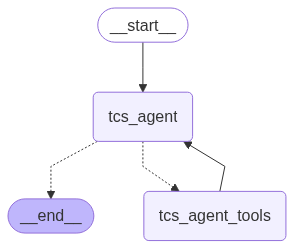

In [14]:
graph_builderd_graph = create_workflow_graph()
graph = graph_builderd_graph.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
for event in graph.stream({"messages": [("user", "What is earnings of TCS in this quarter?")]}):
    if "tcs_agent" in event:
        print("-------------------------------------------------------------------------")
        content = event.get("tcs_agent")["messages"].content

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "What is earnings of TCS in this quarter?"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:tcs_agent] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:tcs_agent > chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:tcs_agent > chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:tcs_agent > chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:LangGraph > chain:tcs_agent > chain:RunnableSequence > llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "System:  You are a helpful TCS assistant that is specialized in answering queries based on TCS RAG database.\nBased on the user query ansewer the user query with the correct answer. Use provided tools t

In [18]:
print("Answer:",content)

Answer: The earnings (profit for the year) of TCS in this quarter (financial year ended March 31, 2024) is ₹46,099 crore.
